<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Purpose" data-toc-modified-id="Purpose-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Purpose</a></span></li><li><span><a href="#Input" data-toc-modified-id="Input-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Input</a></span></li><li><span><a href="#Output" data-toc-modified-id="Output-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Output</a></span></li><li><span><a href="#Parameters" data-toc-modified-id="Parameters-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Parameters</a></span><ul class="toc-item"><li><span><a href="#Not-through-papermill" data-toc-modified-id="Not-through-papermill-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Not through papermill</a></span></li></ul></li><li><span><a href="#Load-Cell-Metadata" data-toc-modified-id="Load-Cell-Metadata-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Load Cell Metadata</a></span></li><li><span><a href="#Basic-metrics-distribution" data-toc-modified-id="Basic-metrics-distribution-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Basic metrics distribution</a></span></li><li><span><a href="#Filter-by-basic-QC-metrics" data-toc-modified-id="Filter-by-basic-QC-metrics-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Filter by basic QC metrics</a></span></li><li><span><a href="#Other-Stats" data-toc-modified-id="Other-Stats-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Other Stats</a></span></li><li><span><a href="#Plateview-of-key-metrics" data-toc-modified-id="Plateview-of-key-metrics-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Plateview of key metrics</a></span></li></ul></div>

# Basic Data Walkthrough and Cell Mapping Metric Filtering

## Purpose
- Overview of basic QC metrics per brain region
- Have a simple cell filtering based on basic QC metrics

## Input
- Cell metadata table

## Output
- Selected cell metadata table

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from cemba_data.plot.preprocessing import cutoff_vs_cell_remain, plot_on_plate

In [3]:
result_dir = pathlib.Path()
fig_dir = result_dir / 'fig/cell_basic_qc'
fig_dir.mkdir(exist_ok=True, parents=True)

## Parameters

In [4]:
# parameters cell
study_name = ''

cell_metadata_path = ''

In [5]:
# Parameters
study_name = "OLF-Exc"
cell_metadata_path = "/home/hanliu/project/mouse_rostral_brain/study/Level3-SubCellType/OLF-Exc/CellMetadata.msg"


### Not through papermill

In [6]:
# QC metric filtering
qc_metric = {
    'CCC_Rate': (0, 0.05),
    'CG_RateAdj': (0.5, 1),
    'CH_RateAdj': (0., 0.15),
    'FinalReads': (500000, 10000000),
    'MappingRate': (0.5, 1)
}

# plot cell metadata columns
metadata_distribution_plot = {
    'CCC_Rate': (0., 0.1),
    'CH_RateAdj': (0, 0.1),
    'CG_RateAdj': (0.7, 0.9),
    'InputReads': (0, 1e7),
    'MappedReads': (0, 1e7),
    'FinalReads': (0, 1e7),
    'MappingRate': (0.5, 1)
}

final_reads_column = 'FinalReads'
plate_view = False

## Load Cell Metadata

In [7]:
total_cell_meta = pd.read_msgpack(cell_metadata_path)

In [8]:
cell_metadata_include = {}
cell_metadata_exclude = {}

# apply cell metadata and cell list selection first
judges = []
for k, v in cell_metadata_include.items():
    judges.append(total_cell_meta[k].isin(v))
for k, v in cell_metadata_exclude.items():
    judges.append(~total_cell_meta[k].isin(v))

if len(judges) != 0:
    cell_meta = total_cell_meta[np.all(judges, axis=0)].copy()
else:
    cell_meta = total_cell_meta

## Basic metrics distribution

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


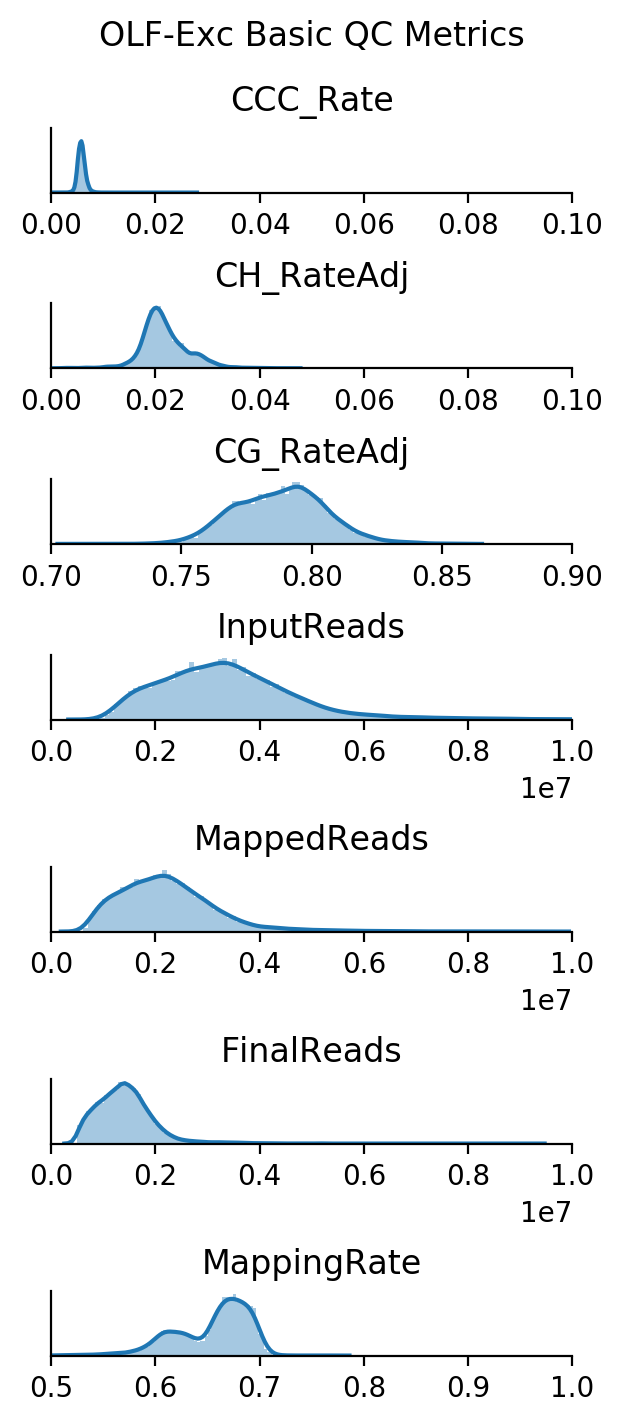

In [9]:
nrows = len(metadata_distribution_plot)
if nrows != 0:
    fig, axes = plt.subplots(nrows=nrows,
                             constrained_layout=True,
                             figsize=(3, nrows),
                             dpi=200)
    for (col, xlim), ax in zip(metadata_distribution_plot.items(), axes.flat):
        _data = cell_meta[col]
        _data = _data[(_data <= xlim[1]) & (_data >= xlim[0])]
        sns.distplot(_data, ax=ax, bins=100)
        ax.set(xlim=xlim, yticks=[], xlabel='', title=col)
    sns.despine(fig=fig, trim=True)

    fig.suptitle(f'{study_name} Basic QC Metrics')

    fig.savefig(fig_dir / f'basic_qc_metric.pdf')

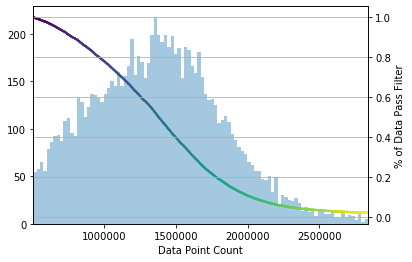

In [10]:
try:
    fig, axes = cutoff_vs_cell_remain(cell_meta[final_reads_column],
                                      xlim_quantile=(0.001, 0.98))
    fig.savefig(fig_dir / 'FinalReads distribution')
except KeyError:
    print(f'{final_reads_column} not in cell_meta, skip')

## Filter by basic QC metrics

In [11]:
judges = []
for col, (vmin, vmax) in qc_metric.items():
    judge = (cell_meta[col] >= vmin) & (cell_meta[col] <= vmax)
    print(
        f'{col} passed {judge.sum()}/{judge.size} ({(100*judge.sum()/judge.size):.1f}%)'
    )
    judges.append(judge)
cell_meta['PassFilter'] = np.all(judges, axis=0)

total_number = cell_meta['PassFilter'].sum()
print(
    f'Overall passed {total_number}/{judge.size} ({(100*total_number/cell_meta.shape[0]):.1f}%)'
)

CCC_Rate passed 9681/9681 (100.0%)
CG_RateAdj passed 9681/9681 (100.0%)
CH_RateAdj passed 9681/9681 (100.0%)
FinalReads passed 9681/9681 (100.0%)
MappingRate passed 9681/9681 (100.0%)
Overall passed 9681/9681 (100.0%)


In [12]:
cell_meta.to_msgpack('CellMetadata.AfterQC.msg')

## Other Stats

In [13]:
print('Cells pass basic QC in each batch:')
for k, v in cell_meta.groupby('FACS_Date')['PassFilter'].sum().astype(
        int).items():
    print(k, v)

Cells pass basic QC in each batch:
171214 4
171219 9
180109 76
180110 19
180111 3
180129 1
180205 1
180208 457
180212 451
180213 2
180220 611
180222 461
180227 9
180312 1
180313 362
180319 211
180320 702
180326 684
180329 657
180402 680
180403 921
180405 199
180412 15
180416 9
180419 2
180806 2
180911 1
180917 7
181008 869
181009 738
181204 1
181218 43
181220 137
190131 634
190205 702


In [14]:
print('Cells pass basic QC in each random index:')
for k, v in cell_meta.groupby('index_name')['PassFilter'].sum().astype(
        int).items():
    print(k, v, f'{v/3.84:.1f}%')

Cells pass basic QC in each random index:
ad001 1207 314.3%
ad002 1259 327.9%
ad004 1234 321.4%
ad006 1213 315.9%
ad007 1186 308.9%
ad008 1255 326.8%
ad010 1157 301.3%
ad012 1170 304.7%


## Plateview of key metrics

In [15]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'FinalReads',
                              'Plate',
                              vmin=5e5,
                              vmax=3e6,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.FinalReads.pdf')

In [16]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CG_RateAdj',
                              'Plate',
                              vmin=0.65,
                              vmax=0.85,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CG_RateAdj.pdf')

In [17]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CH_RateAdj',
                              'Plate',
                              vmin=0,
                              vmax=0.05,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CH_RateAdj.pdf')

In [18]:
cell_meta

,AllcPath,CCC_Rate,CG_Rate,CG_RateAdj,CH_Rate,CH_RateAdj,FinalReads,InputReads,MappedReads,Region,...,l1-umap_0,l1-umap_1,l1-tsne_0,l1-tsne_1,MajorType,l2-umap_0,l2-umap_1,l2-tsne_0,l2-tsne_1,PassFilter
cell,,,,,,,,,,,,,,,,,,,,,
1A_M_1558,/gale/raidix/rdx-4/CEMBA_RS1/1A/CEMBA180227_1A...,0.004920,0.777690,0.776590,0.025080,0.020260,2459317.0,5632088,3850495.0,1A,...,-9.447071,-14.114122,-10.737638,-0.842778,OLF-Exc,-1.431039,5.200647,35.320231,-45.563021,True
1A_M_1780,/gale/raidix/rdx-4/CEMBA_RS1/1A/CEMBA180227_1A...,0.004530,0.770850,0.769810,0.022240,0.017790,1964814.0,4589180,3093540.0,1A,...,-9.093311,-14.789703,-12.083312,-0.088999,OLF-Exc,-0.931250,3.639914,39.466275,-42.690995,True
1A_M_1885,/gale/raidix/rdx-4/CEMBA_RS1/1A/CEMBA180227_1A...,0.004320,0.766530,0.765520,0.020620,0.016370,3010991.0,6597858,4532002.0,1A,...,-7.742332,-13.054474,-8.724957,4.869713,OLF-Exc,1.094366,3.329568,38.235103,-34.036966,True
1A_M_1910,/gale/raidix/rdx-4/CEMBA_RS1/1A/CEMBA180227_1A...,0.005030,0.765040,0.763850,0.022890,0.017950,1488979.0,3523882,2369402.0,1A,...,-9.345468,-13.881258,-10.230655,-1.401413,OLF-Exc,-1.148184,4.882761,37.064553,-47.202425,True
1A_M_1980,/gale/raidix/rdx-4/CEMBA_RS1/1A/CEMBA180227_1A...,0.003640,0.748870,0.747950,0.014820,0.011220,4335964.0,10007240,6838454.0,1A,...,-8.834912,-11.877346,-6.557444,-1.963602,OLF-Exc,-1.046899,5.663275,34.520704,-48.108053,True
1A_M_2289,/gale/raidix/rdx-4/CEMBA_RS1/1A/CEMBA180227_1A...,0.004410,0.759960,0.758900,0.021310,0.016970,1469535.0,4090596,2200570.0,1A,...,-9.220057,-15.315604,-13.600826,-0.775842,OLF-Exc,-1.156334,3.174955,41.835155,-42.749695,True
1A_M_2321,/gale/raidix/rdx-4/CEMBA_RS1/1A/CEMBA180227_1A...,0.004380,0.758140,0.757080,0.022390,0.018090,2006020.0,4553742,3061620.0,1A,...,-9.216571,-14.099162,-10.497025,-0.300826,OLF-Exc,-0.961737,4.223951,37.613456,-43.567225,True
1A_M_2376,/gale/raidix/rdx-4/CEMBA_RS1/1A/CEMBA180227_1A...,0.004190,0.771790,0.770830,0.020650,0.016530,2415790.0,5112594,3488525.0,1A,...,-6.734130,-12.233208,-12.790005,7.412311,OLF-Exc,0.446833,4.270948,38.810683,-36.267391,True
1A_M_2400,/gale/raidix/rdx-4/CEMBA_RS1/1A/CEMBA180227_1A...,0.004550,0.763050,0.761970,0.021410,0.016940,2288037.0,5201070,3528753.0,1A,...,-9.648846,-14.401578,-11.179558,-0.920141,OLF-Exc,-1.524585,4.226729,38.250855,-45.161817,True
